# Gempy Methods and Features
In this notebook, we present some of the main features of GemPy (and the corresponding methods used), which will be useful for the [PS Geothermie Aargau](https://geg.ethz.ch/project-geothermal_aargau/) study. 

That means, we will look at *input data*, *model generation*, *visualization*, *changing models*, *export*. The majority of these features can already be tested in the [GemPy tutorials](https://www.gempy.org/tutorials). Here, we showcase the features and necessary methods in a rather short form.  

# Input data
Input data in GemPy is based on the `csv` format, i.e. comma-separated-values. While the type of data may seem natural to geologists, it won't hurt to explain it a bit more.

In geology, rock units with different properties are stacked on top of each other with the younger rocks lying on top of older rocks. Presuming of course, nothing else (i.e. tectonics) happened to them afterwards. The interface between different rock units can be mapped, e.g. in classical field work at the earth's surface, or on seismic sections and in boreholes in the subsurface.  
To specify a point in space, you need its coordinates, i.e. `x`, `y`, and `z`. But since these interfaces are, e.g. outcrops, roughly a 2D line, but in reality a surface in 3D, we need more information than just coordinates. To define a plane in 3D, we need its orientation, which usually is defined by *azimuth* and *inclination*, i.e. *angle deviation from north* and *angle deviation from the horizontal plan*. Geologists in the field measure these angles with a compass for instance. 

In summary, GemPy input data comprises two types interface points:  

| x  | y  | z  | Formation  |  
|--:|--:|--:|---|  
|  200 | 250  | 520  | sandstone  |  
|  400 | 250  | 550  | sandstone  |  
|  200 | 550  | 700  | limestone  |  

 and orientation points:  
 
| x  |  y |  z |  azimuth | dip  | polarity  |  Formation |
|--:|--:|--:|--:|--:|--:|---|
| 300  | 250  | 545  | 90  | 10  |  1 | sandstone  |
|  300 |  550 |  680 |  90 | 15  |  1 | limestone  |

In [1]:
# import libraries
import gempy as gp
import matplotlib.pyplot as plt
%matplotlib inline

With this two data types, we can set up a model in GemPy. This can be done in two ways (currently). Either by first defining the `model` and then assigning the input data, or by doing it in one step via `create_data`.

In [2]:
# 1st option
geo_model = gp.create_model('Trough')

# set model extent and feed it some input data
gp.init_data(geo_model, [0, 400., 0, 1400., 0, 1000.], [8, 100, 100],
                        path_o = '../data/graben_test_orientations.csv',
                        path_i = '../data/graben_test_interfaces.csv', default_values=False);

Active grids: ['regular']


In [3]:
# 2nd option
geo_model = gp.create_data([0, 400., 0, 1400., 0, 1000.], [8, 100, 100],
                        path_o = '../data/graben_test_orientations.csv',
                        path_i = '../data/graben_test_interfaces.csv', default_values=False);

Active grids: ['regular']


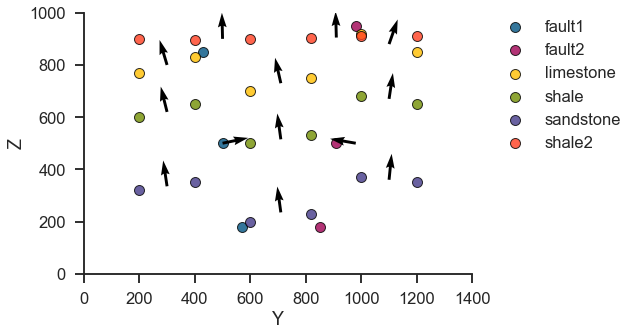

In [4]:
# display of the data we loaded
gp.plot.plot_data(geo_model, direction='x')

# Creating of Series  
Rock units have a certain age, the age of crystallization, sedimentation, etc. In geology, these packages of rocks can be divided based on their age to form [Series](https://en.wikipedia.org/wiki/Series_(stratigraphy)). 

In GemPy, Units can be comprised into Series as well. However, the term *Series* does not strictly relate to stratigraphy in GemPy. Technically, it comprises Units which will share parameters for their spatial interpolation. This makes sense, if you think of a sequence of rocks which was deposited on top of each other, forming a layered sequence which may be modelled with the same set of parameters.  
Strong spatial changes of rock units, but also faults, need their own "Series" to be modelled best. We now assign rocks to particular series, in order to bring some order in our data and to tell GemPy, what is the oldest, and what is the youngest unit in our model.

In [5]:
gp.map_series_to_surfaces(geo_model,
                         {"Fault1_Series": 'fault1',
                         "Fault2_Series": 'fault2',
                         "Postgraben_Series": 'shale2',
                         "Pregraben_Series": ('sandstone', 'shale', 'limestone')},
                         remove_unused_series=True)

,surface,series,order_surfaces,isBasement,color,id
0,fault1,Fault1_Series,1,False,#015482,1
1,fault2,Fault2_Series,1,False,#9f0052,2
5,shale2,Postgraben_Series,1,False,#ff3f20,3
2,limestone,Pregraben_Series,1,False,#ffbe00,4
3,shale,Pregraben_Series,2,False,#728f02,5
4,sandstone,Pregraben_Series,3,False,#443988,6
6,basement,Basement,1,True,#325916,7


## Series relation  
Several characteristics can be set to each series:  
* `bottomrelation`  if it is eroding or onlapping (i.e. cutting through older or stopping at older formations)  
* `is_fault` if a series comprises a fault  
[and some more](https://gempy.readthedocs.io/Data/data.Series.html)

In [6]:
geo_model.series

,order_series,BottomRelation
Fault1_Series,1,Erosion
Fault2_Series,2,Erosion
Postgraben_Series,3,Erosion
Pregraben_Series,4,Erosion
Basement,5,Erosion


In [12]:
# so let's set the Pregraben_Series to Onlap
geo_model.series.set_bottom_relation(['Postgraben_Series','Pregraben_Series'], bottom_relation='Onlap')

,order_series,BottomRelation
Fault1_Series,1,Fault
Fault2_Series,2,Fault
Postgraben_Series,3,Onlap
Pregraben_Series,4,Onlap
Basement,5,Erosion


In [8]:
# And make sure that fault1 and fault2 are seen as faults  
geo_model.set_is_fault(['Fault1_Series', 'Fault2_Series'])
#geo_model.set_is_finite_fault(['Fault1_Series', 'Fault2_Series'], toggle=True)

Fault colors changed. If you do not like this behavior, set change_color to False.


,isFault,isFinite
Fault1_Series,True,False
Fault2_Series,True,False
Postgraben_Series,False,False
Pregraben_Series,False,False
Basement,False,False


# Calculate the model 
Now with units assigned to Series we can go forward and calculate the model. For this, we set the interpolation function using theano.

In [13]:
# Create the theano model  
gp.set_interpolation_data(geo_model, compile_theano=True,
                         theano_optimizer='fast_compile')

Compiling theano function...
Compilation Done!


In [14]:
# Compute the model
solution = gp.compute_model(geo_model, compute_mesh=False)

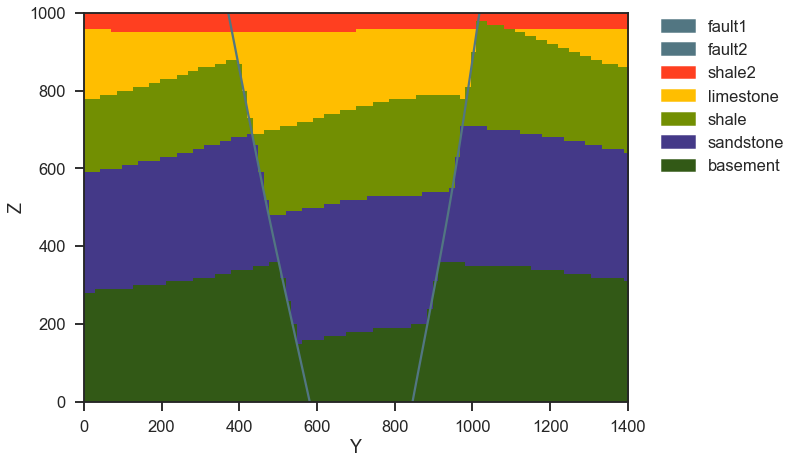

In [15]:
gp.plot.plot_section(geo_model, cell_number=4, direction='x')